In [1]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

In [2]:
#define a dictionary of cover types
CoverTypes={1.0: 'Spruce/Fir',
            2.0: 'Lodgepole Pine',
            3.0: 'Ponderosa Pine',
            4.0: 'Cottonwood/Willow',
            5.0: 'Aspen',
            6.0: 'Douglas-fir',
            7.0: 'Krummholz' }
print 'Tree Cover Types:'
CoverTypes

Tree Cover Types:


{1.0: 'Spruce/Fir',
 2.0: 'Lodgepole Pine',
 3.0: 'Ponderosa Pine',
 4.0: 'Cottonwood/Willow',
 5.0: 'Aspen',
 6.0: 'Douglas-fir',
 7.0: 'Krummholz'}

In [3]:
# creating a directory called covtype, download and decompress covtype.data.gz into it

from os.path import exists
if not exists('covtype'):
    print "creating directory covtype"
    !mkdir covtype
%cd covtype
if not exists('covtype.data'):
    if not exists('covtype.data.gz'):
        print 'downloading covtype.data.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
    print 'decompressing covtype.data.gz'
    !gunzip -f covtype.data.gz
!ls -l
%cd ..

/home/shanmathi/CSE255/spark-1.6.0-bin-hadoop2.6/covtype
total 73412
-rw-rw-r-- 1 shanmathi shanmathi 75169317 May 20 19:44 covtype.data
/home/shanmathi/CSE255/spark-1.6.0-bin-hadoop2.6


In [3]:
# Define the feature names
cols_txt="""
Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology,
Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways,
Hillshade_9am, Hillshade_Noon, Hillshade_3pm,
Horizontal_Distance_To_Fire_Points, Wilderness_Area (4 binarycolumns), 
Soil_Type (40 binary columns), Cover_Type
"""

In [4]:
# Break up features that are made out of several binary features.
from string import split,strip
cols=[strip(a) for a in split(cols_txt,',')]
colDict={a:[a] for a in cols}
colDict['Soil_Type (40 binary columns)'] = ['ST_'+str(i) for i in range(40)]
colDict['Wilderness_Area (4 binarycolumns)'] = ['WA_'+str(i) for i in range(4)]
Columns=[]
for item in cols:
    Columns=Columns+colDict[item]
print Columns

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WA_0', 'WA_1', 'WA_2', 'WA_3', 'ST_0', 'ST_1', 'ST_2', 'ST_3', 'ST_4', 'ST_5', 'ST_6', 'ST_7', 'ST_8', 'ST_9', 'ST_10', 'ST_11', 'ST_12', 'ST_13', 'ST_14', 'ST_15', 'ST_16', 'ST_17', 'ST_18', 'ST_19', 'ST_20', 'ST_21', 'ST_22', 'ST_23', 'ST_24', 'ST_25', 'ST_26', 'ST_27', 'ST_28', 'ST_29', 'ST_30', 'ST_31', 'ST_32', 'ST_33', 'ST_34', 'ST_35', 'ST_36', 'ST_37', 'ST_38', 'ST_39', 'Cover_Type']


In [5]:
# Have a look at the first two lines of the data file
!head -2 covtype/covtype.data

2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [6]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='covtype/covtype.data'
inputRDD=sc.textFile(path)
inputRDD.first()

u'2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5'

In [7]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
                .map(lambda x : LabeledPoint (x[-1] , x[0:-1] ))
Data.first()

LabeledPoint(5.0, [2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])

In [8]:
# count the number of examples of each type
total=Data.cache().count()
print 'total data size=',total

counts=Data.map(lambda x: (x.label,1)).reduceByKey(lambda x,y: x+y).collect()

counts.sort(key=lambda x:x[1],reverse=True)
print '              type (label):   percent of total'
print '---------------------------------------------------------'
print '\n'.join(['%20s (%3.1f):\t%4.2f'%(CoverTypes[a[0]],a[0],100.0*a[1]/float(total)) for a in counts])

total data size= 581012
              type (label):   percent of total
---------------------------------------------------------
      Lodgepole Pine (2.0):	48.76
          Spruce/Fir (1.0):	36.46
      Ponderosa Pine (3.0):	6.15
           Krummholz (7.0):	3.53
         Douglas-fir (6.0):	2.99
               Aspen (5.0):	1.63
   Cottonwood/Willow (4.0):	0.47


In [9]:
Label=2.0
Data=inputRDD.map(lambda line: [float(x) for x in line.split(',')])\
    .map(lambda V: LabeledPoint(1.0,V[0:-1]) if V[-1]==Label else LabeledPoint(0.0,V[0:-1]) )
 

In [10]:
Data1=Data.sample(False,0.1).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=58030, trainingData=40606, testData=17424


In [11]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(0.0, 8917), (1.0, 8507)]

In [12]:
from time import time
errors={}
categoricalFeaturesInfo = {}
for i in range(10,54):
    categoricalFeaturesInfo[i] = 2
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,categoricalFeaturesInfo,numIterations=10,maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features)) 
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.2644628099173554, 'train': 0.2711421957346205} 7 seconds
3 {'test': 0.24793388429752067, 'train': 0.2520070925478993} 5 seconds
6 {'test': 0.204143709825528, 'train': 0.20208836132591243} 6 seconds
10 {'test': 0.16138659320477503, 'train': 0.12611436733487663} 12 seconds
{1: {'test': 0.2644628099173554, 'train': 0.2711421957346205}, 10: {'test': 0.16138659320477503, 'train': 0.12611436733487663}, 3: {'test': 0.24793388429752067, 'train': 0.2520070925478993}, 6: {'test': 0.204143709825528, 'train': 0.20208836132591243}}


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


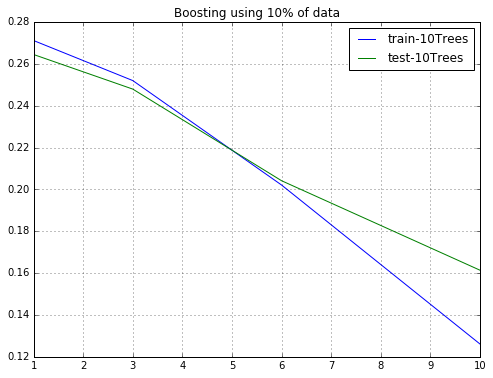

In [13]:
B10 = errors
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

In [14]:
from time import time
errors={}
categoricalFeaturesInfo = {}
for i in range(10,54):
    categoricalFeaturesInfo[i] = 2
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData,2,categoricalFeaturesInfo,numTrees=10,maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        predictions = model.predict(data.map(lambda x: x.features))
        labelsAndPredictions = data.map(lambda lp: lp.label).zip(predictions)
        Err = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(data.count())
        errors[depth][name]=Err
       
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.49959825528007346, 'train': 0.4983253706348815} 1 seconds
3 {'test': 0.36685032139577595, 'train': 0.36851696793577304} 1 seconds
6 {'test': 0.2673324150596878, 'train': 0.27279219819731076} 1 seconds
10 {'test': 0.22974058769513314, 'train': 0.2321824360931882} 2 seconds
15 {'test': 0.1922635445362718, 'train': 0.1815002708959267} 4 seconds
20 {'test': 0.185376492194674, 'train': 0.1646308427326011} 6 seconds
{1: {'test': 0.49959825528007346, 'train': 0.4983253706348815}, 3: {'test': 0.36685032139577595, 'train': 0.36851696793577304}, 6: {'test': 0.2673324150596878, 'train': 0.27279219819731076}, 10: {'test': 0.22974058769513314, 'train': 0.2321824360931882}, 15: {'test': 0.1922635445362718, 'train': 0.1815002708959267}, 20: {'test': 0.185376492194674, 'train': 0.1646308427326011}}


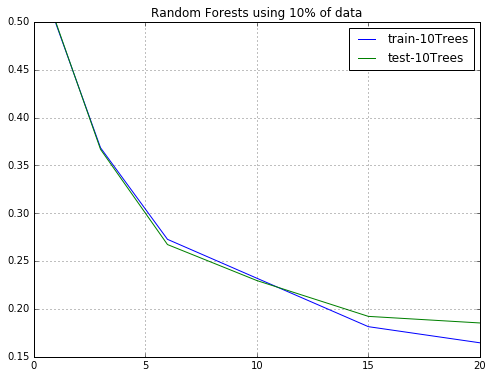

In [15]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')

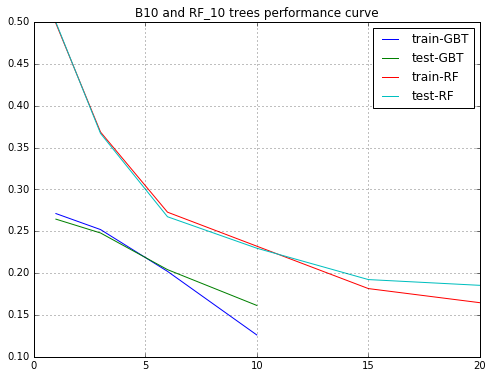

In [16]:
make_figure([B10,RF_10trees],['GBT','RF'],Title='B10 and RF_10 trees performance curve')